In this notebook I investigate the effect of inequality reduction on GHG emissions

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kde import *
from perc import *
%matplotlib inline

from wb_api_wraper import *


pd.set_option('display.max_colwidth', 200)
pd.set_option('display.width', 200)
pd.set_option('display.precision', 2)
pd.set_option('display.max_rows', 500)


In [2]:
datadir = "csvdata/";

In [3]:
any_name_to_wb_name = pd.read_csv("any_name_to_wb_name.csv",index_col="any",squeeze=True)
iso_to_name = pd.read_csv("iso3_to_wb_name.csv",usecols=["iso3","country"],index_col="iso3",squeeze=True)
names_to_iso = pd.read_csv("names_to_iso.csv",usecols=["country","iso3"],index_col="country",squeeze=True)

###Data from World bank API

In [170]:
wb_pop = get_wb_mrv("SP.POP.TOTL","wb_pop").wb_pop
wb_emis = get_wb_mrv("EN.ATM.CO2E.FF.KT","wb_emis").wb_emis #CO2 emissions from fossil fuels, total;

###Data from Maros

In [10]:
#personal data
persdata=pd.read_csv("csvdata/PERSDATA.csv").replace(iso_to_name)  #here emost of weights are 1 but some weights are 0.6
persdata.columns = map(str.lower, persdata.columns)
persdata=persdata.set_index("schema").drop("arm04").reset_index()#drops armenia 2004 since we have armenia 2012
persdata.schema.unique() #countries should apper only once

array(['alb05', 'arm12', 'gha06', 'ind05', 'irq06', 'lbr07', 'mda12',
       'mwi11', 'ner11', 'rwa11', 'sen11', 'sle11', 'vnm12'], dtype=object)

In [11]:
#household data
hhdata = pd.read_csv("csvdata/HHLDDATA.csv").replace(iso_to_name)
hhdata.columns = map(str.lower, hhdata.columns)
hhdata = hhdata.set_index("schema").drop("arm04").reset_index()#drops armenia 2004 since we have armenia 2012
hhdata.schema.unique()#countries should apper only once

array(['alb05', 'arm12', 'bgd05', 'gha06', 'ind05', 'irq06', 'lbr07',
       'mda12', 'mwi11', 'ner11', 'rwa11', 'sen11', 'sle11', 'vnm12'], dtype=object)

In [2]:
persdata.head()

NameError: name 'persdata' is not defined

In [3]:
#emissions per household and per capita
emis_hh = pd.read_csv("csvdata/emissionsbyhousehold.csv").replace(iso_to_name).rename(columns={"value": "emis_hh"})
emis_hh.schema.unique() #countries should apper only once (Armenia  is only once in emissionsbyhousehold)

NameError: name 'pd' is not defined

In [13]:
weight_hh = hhdata.set_index(['country',"hid"])["weight"]

In [14]:
#number of persons per household
nb_people_in_hh =persdata.groupby(["country","hid"])["pid"].count()
nb_people_in_hh.name = "nb_people_in_hh"
nb_people_in_hh.head();
#total number of people in the economy
nb_people_tot = (weight_hh*nb_people_in_hh).sum(level="country")
(nb_people_tot/wb_pop).dropna()

country
Albania         0.412566
Armenia         0.759794
Ghana           0.872517
India           0.796689
Iraq            0.900637
Liberia         0.630027
Malawi          0.861687
Moldova         0.942429
Niger           0.933535
Rwanda          0.190569
Senegal         0.964585
Sierra Leone    0.971050
Vietnam         0.995079
dtype: float64

Previous cell confirms how I should compute population from HHdata

In [54]:
#emissions per household and per capita
expend = pd.read_csv("csvdata/PerCapitaExpenditures.csv").replace(iso_to_name).rename(columns={"value": "expend"})
expend.schema.unique()

array(['alb05', 'arm12', 'gha06', 'ind05', 'irq06', 'lbr07', 'mda12',
       'mwi11', 'ner11', 'rwa11', 'sen11', 'sle11', 'vnm12'], dtype=object)

In [156]:
df["expend"] = expend.set_index(["country","hid"]).expend

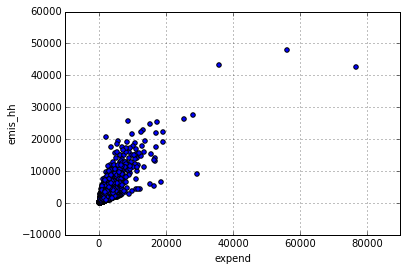

In [161]:
df.ix["Vietnam"].plot(x="expend",y="emis_hh",kind="scatter")

###Gtap

In [86]:
gtap_to_wb_name = pd.read_csv("gtap_to_wb_name.csv",index_col="gtap_region",squeeze=True)
gtap_to_wb_name;

In [92]:
gtap = pd.read_csv("sec_data_gtap.csv").replace(gtap_to_wb_name)
gtap["country"]=gtap.gtap_region.str.upper().str.strip().replace(gtap_to_wb_name)
gtap =gtap.set_index(["country","cpc2"]).drop(["gtap_region"],axis=1)

In [95]:
gtap.conso_usd.sum(level="country");

In [99]:
((expend.set_index(["country","hid"]).expend * nb_people_in_hh ).sum(level="country") / gtap.conso_usd.sum(level="country")).dropna()

country
Albania     1373.707753
Armenia    71490.357402
Ghana       1694.098739
India          0.017943
Malawi      3751.635446
Rwanda      8300.920880
Senegal     3299.749168
Vietnam      644.993301
dtype: float64

NY.GDP.MKTP.CD 	GDP (current US$)  #mean .55, not that bad
NY.GDP.MKTP.CN 	GDP (current LCU)
NY.GDP.MKTP.KD 	GDP (constant 2005 US$)
NY.GDP.MKTP.KN 	GDP (constant LCU)
NY.GDP.MKTP.PP.CD 	GDP, PPP (current international $)
NY.GDP.MKTP.PP.KD 	GDP, PPP (constant 2011 international $)

In [134]:
(1e6* gtap.conso_usd.sum(level="country") / get_wb_mrv("NY.GDP.MKTP.KN","foo").foo).dropna();

In [167]:
((gtap.conso_usd*gtap.emissions_g_usd).sum(level="country")/wb_emis).dropna()

country
Albania                 1.1
Argentina               0.5
Armenia                 1.1
Australia               0.7
Austria                 1.3
Azerbaijan              0.6
Bahrain                 0.4
Bangladesh              0.9
Belarus                 0.5
Belgium                 0.8
Benin                   1.0
Bolivia                 0.5
Botswana                0.6
Brazil                  1.2
Brunei Darussalam       0.3
Bulgaria                0.5
Burkina Faso            1.3
Cambodia                1.5
Cameroon                1.0
Canada                  0.8
Chile                   0.8
China                   0.1
Colombia                1.1
Costa Rica              1.3
Cote d'Ivoire           1.3
Croatia                 0.9
Cyprus                  1.0
Czech Republic          0.5
Denmark                 0.9
Dominican Republic      1.1
Ecuador                 0.8
Egypt, Arab Rep.        0.5
El Salvador             1.6
Estonia                 0.3
Ethiopia                1.9
Finland     

###df

In [15]:
#checks sanity with the index
emis_hh[['country',"hid"]].duplicated().sum()  , hhdata[['country',"hid"]].duplicated().sum()

(0, 0)

In [149]:
df= pd.concat([nb_people_in_hh,weight_hh,emis_hh.set_index(["country","hid"])["emis_hh"]],axis=1)

In [150]:
df.columns

Index(['nb_people_in_hh', 'weight', 'emis_hh'], dtype='object')

In [172]:
(df[[ 'weight', 'emis_hh']].prod(axis=1).sum(level="country")/(1e6*wb_emis)).dropna()

country
Ghana           1.7
Liberia         1.8
Malawi          1.9
Niger           5.7
Rwanda          2.5
Senegal         1.9
Sierra Leone    1.2
dtype: float64

In [163]:
df[[ 'weight', 'emis_hh']].prod(axis=1).sum(level="country")/1e6

country
Albania           1040.7
Armenia          73540.8
Bangladesh          28.6
Ghana            12608.7
India           190666.9
Iraq             32023.0
Liberia            938.0
Malawi            1989.7
Moldova          39824.4
Niger             6601.2
Rwanda            1796.0
Senegal           8885.2
Sierra Leone      1653.7
Vietnam          57155.5
dtype: float64

In [153]:
(df[[ 'weight', 'emis_hh']].prod(axis=1).sum(level="country"))

country
Albania         1.0e+09
Armenia         7.4e+10
Bangladesh      2.9e+07
Ghana           1.3e+10
India           1.9e+11
Iraq            3.2e+10
Liberia         9.4e+08
Malawi          2.0e+09
Moldova         4.0e+10
Niger           6.6e+09
Rwanda          1.8e+09
Senegal         8.9e+09
Sierra Leone    1.7e+09
Vietnam         5.7e+10
dtype: float64

In [25]:
(df[['nb_people_in_hh',  'emis_hh']].prod(axis=1).sum(level="country")/wb_emis).dropna()

country
Ghana            11569.724725
Liberia          74623.075227
Malawi           39678.283600
Niger           171889.152776
Rwanda           16620.793017
Senegal          68731.240231
Sierra Leone     50327.673803
dtype: float64

In [44]:
df.columns

Index(['nb_people_in_hh', 'weight', 'emis_hh', 'prod'], dtype='object')

In [51]:
((df.emis_hh/(df.weight*df.nb_people_in_hh)).sum(level="country")/wb_emis).dropna()

country
Ghana             1.584868
Liberia          40.918310
Malawi           15.435595
Niger            31.996557
Rwanda          119.544156
Senegal          11.144409
Sierra Leone     15.401058
dtype: float64

In [ ]:
(df[['nb_people_in_hh', 'weight', 'emis_hh']].prod(axis=1).sum(level="country")/wb_emis).dropna()

###Data from GTAP and computation in SQL

In [35]:
gtap_emis = pd.read_csv("tot_emis_gtap.csv",header=None,names=["country","emis"],index_col = "country", squeeze=True)

In [36]:
gtap_emis;

In [38]:
(gtap_emis / wb_emis).dropna()

country
Benin               1.110148
Botswana            0.678491
Burkina Faso        1.268314
Cote d'Ivoire       1.109351
Egypt, Arab Rep.    0.512281
Ethiopia            1.524031
Ghana               1.599943
Guinea              1.541588
Kenya               0.837620
Madagascar          1.847151
Malawi              1.886472
Mauritius           0.878304
Morocco             0.648597
Mozambique          2.624023
Namibia             0.743559
Nigeria             1.002656
Rwanda              1.891985
Senegal             1.120419
South Africa        0.194588
Tanzania            1.059062
Togo                1.326361
Tunisia             0.621414
Uganda              1.259882
Zambia              4.171393
Zimbabwe            0.879348
dtype: float64

In [52]:
(gta{ap_emis / tot_emis_maybe).dropna()

,Albania,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,Bangladesh,Belarus,Belgium,...,XSE,XSM,XSU,XTW,XWF,XWS,Zambia,Zimbabwe,emis_hh,year
country,,,,,,,,,,,,,,,,,,,,,


In [29]:
wb_emis.ix[wb_emis.index]

country
Albania              NaN
Armenia              NaN
Bangladesh           NaN
Ghana           7444.010
India                NaN
Iraq                 NaN
Liberia          524.381
Malawi          1059.763
Moldova              NaN
Niger           1158.772
Rwanda           726.066
Senegal         4576.416
Sierra Leone    1415.462
Vietnam              NaN
Name: wb_emis, dtype: float64

In [16]:
wb_emis = wb_emis.ix[tot_emis.index]

In [27]:
tot_emis

country
Albania         1.040662e+09
Armenia         1.282214e+11
Bangladesh               NaN
Ghana           1.260871e+10
India           1.906669e+11
Iraq            3.202297e+10
Liberia         9.380252e+08
Malawi          1.989655e+09
Moldova         3.982440e+10
Niger           6.601154e+09
Rwanda          1.795978e+09
Senegal         8.885214e+09
Sierra Leone    1.653691e+09
Vietnam         5.715552e+10
dtype: float64

###Data from IEA

In [144]:

iea_emis=pd.read_csv("carbon_emissions_from_iea.csv",skiprows=[1],na_values=[".."]).dropna(axis=1,how="all").dropna().replace(any_name_to_wb_name).set_index("country")
iea_emis = iea_emis.ix[wb_emis.index].astype("float")

In [145]:
iea_emis

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
country,,,,,,,,,,
Africa,6.5e+01,7.1e+01,7.9e+01,8.4e+01,8.6e+01,9.1e+01,9.4e+01,9.9e+01,1.1e+02,1.1e+02
Algeria,1.8e+01,1.9e+01,2.0e+01,2.1e+01,2.1e+01,2.3e+01,2.4e+01,2.4e+01,2.6e+01,2.8e+01
Angola,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00
Benin,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00
Botswana,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00
Burkina Faso,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Burundi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cape Verde,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Central African Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
wb_emis

country
Albania              NaN
Armenia              NaN
Bangladesh           NaN
Ghana           7444.010
India                NaN
Iraq                 NaN
Liberia          524.381
Malawi          1059.763
Moldova              NaN
Niger           1158.772
Rwanda           726.066
Senegal         4576.416
Sierra Leone    1415.462
Vietnam              NaN
Name: wb_emis, dtype: float64

In [20]:
iea_emis.iloc[:,-1]

NameError: name 'iea_emis' is not defined

###Comparing various sources

In [21]:
(tot_pop/wb_pop).dropna()

country
Albania         0.412566
Armenia         3.624206
Ghana           0.872517
India           0.796689
Iraq            0.900637
Liberia         0.630027
Malawi          0.861687
Moldova         0.942429
Niger           0.933535
Rwanda          0.190569
Senegal         0.964585
Sierra Leone    0.971050
Vietnam         0.995079
dtype: float64

In [22]:
wb_emis_pc=wb_emis_pc.ix[tot_emis.index]
wb_emis = wb_emis.ix[tot_emis.index] #kilotons, for some reason
wb_emis;

NameError: name 'wb_emis_pc' is not defined

In [23]:
tot_emis/wb_emis

country
Albania                    NaN
Armenia                    NaN
Bangladesh                 NaN
Ghana           1693805.518934
India                      NaN
Iraq                       NaN
Liberia         1788823.758953
Malawi          1877452.705637
Moldova                    NaN
Niger           5696680.335304
Rwanda          2473574.510851
Senegal         1941522.382588
Sierra Leone    1168304.614147
Vietnam                    NaN
dtype: float64

In [26]:
(tot_emis/tot_pop)/(wb_emis_pc)

NameError: name 'wb_emis_pc' is not defined

In [25]:
#expenditures per capita
hh_exp = pd.read_csv("csvdata/PerCapitaExpenditures.csv").replace(iso_to_name)
hh_exp.rename(columns={"value": "hh_exp_pc"},inplace=True)
hh_exp.set_index(["country","hid"],inplace="True")

In [ ]:
#builds dataframe indexed by country and hid with all the data
df = pd.DataFrame(hh_exp["hh_exp_pc"])
df["hh_emi"]=hh_emi["hh_emis"]
df["hh_emi_pc"]=hh_emi_pc
df["nb_people"]=nb_people
df["w"]=hop["weight"]
df["hh_emis_perdol"]=df["hh_emi_pc"]/df["hh_exp_pc"]

#Vietnam 
vn=df.ix["VNM",:]

In [ ]:
def wavg(val_col_name, wt_col_name):
    """computes the average of val_col_name weighted by wt_col_name"""
    def inner(group):
        return (group[val_col_name] * group[wt_col_name]).sum() / group[wt_col_name].sum()
    #inner.__name__ = res_name
    return inner

In [ ]:
flat_df =  df.reset_index()
country_list = flat_df.country.unique()

In [ ]:
#Categories USD per day categories
income_bins = np.array([0,1,1.25,2,2.5,4]+[10*2.**i for i in range(0,15,1)]) 
income_cut = pd.cut(flat_df["hh_exp_pc"]/365, income_bins)

income_cut.unique()


In [ ]:
flat_df

In [ ]:
#
stats = pd.DataFrame()
grouped =flat_df.groupby(["country",income_cut])
stats["avg_emis_pc"]=grouped.apply(wavg('hh_emi_pc', 'w'))
stats["nb_people0"] =grouped["nb_people"].sum()
#stats.sort_index(inplace=True)
#stats["nb_people1"]=grouped["nb_people"]
stats

In [ ]:
#stats.ix[c]
#country_stats

In [ ]:
#for c in country_list:
#def lift_folks(country_stats):
def lift_folks(country_stats):
    #out = pd.DataFrame(index=country_stats.index)
    emis =pd.DataFrame(index=["emis"])
    out= country_stats.ix[:,["nb_people0"]]
    for i in range(1,10):
        nam = 'min'+str(income_bins[i])
        out[nam] = country_stats["nb_people0"]
        out.ix[i,nam] = country_stats.ix[0:i+1,"nb_people0"].sum()
        out.ix[0:i,nam] =0
        #emis[str(i)]= np.average(country_stats["avg_emis_pc"],weights=out[nam])
    return out
 #   stats.ix[c,[out.columns.values]]=out

In [ ]:
emis_sce_country = pd.DataFrame()
#computes new emissions at once
for c in country_list:
    emis_sce_country[c]= stats.ix[c]["avg_emis_pc"].dot(lift_folks(stats.ix[c,:]))/(stats.ix[c]["nb_people0"].sum())
    
emis_sce_country    

In [ ]:
#emis_sce_country['tot']=emis_sce_country.sum(axis=1)  

In [ ]:
(emis_sce_country/emis_sce_country.ix["nb_people0",:]-1)*100

In [ ]:
#paf = stats.reset_index().groupby("country").apply(lift_folks)
#paf.reset_index().groupby("country").apply(wavg("avg_emis_pc","nb_people1"))
#paf

In [ ]:
#pd.concat([flat_df,pd.get_dummies(income_cut)],axis=1).set_index(["country","hid"])
income_cut = pd.cut(df["hh_exp_pc"]/365, income_bins)

income_dummies= pd.get_dummies(income_cut)
df= pd.concat([df,income_dummies],axis=1)
df

In [ ]:
stats.ix[:,"nb_people1"] = stats.ix[:,"nb_people"]
stats.ix[:,"nb_people1"]

In [ ]:
stats.ix[pd.MultiIndex("ALB)]

In [ ]:
wp(vn["hh_exp_pc"],vn["nb_people"],np.arange(0,1,0.1))

In [ ]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(9,7))
plt.plot((df["hh_exp_pc"]),df["hh_emi_pc"]/df["hh_exp_pc"],color="blue",marker='.',markeredgewidth=1,linestyle='None',markersize=12,clip_on=False)
plt.xlabel("$\$/yr$")
plt.ylabel("$gCO_2/\$$")
plt.xscale("log")

In [ ]:
stats.

In [ ]:
def weighted_rolling_mean(x,y,w,kernel):
    

In [ ]:
from statsmodels.nonparametric.kernel_regression import KernelReg
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100) * 0.2
kr = KernelReg(y,x,'o')
plt.plot(x, y, '+')
y_pred, y_std = kr.fit(x)
plt.plot(x, y_pred)

In [ ]:
def plot_distribution(y,w,thecolor="red"):
    hist, bin_edges = np.histogram(y,bins=100,weights=w,density=True)
    width = 0.5 * (bin_edges[1] - bin_edges[0])
    center = (bin_edges[:-1] + bin_edges[1:]) / 2
    xs = np.linspace(center.min(),center.max(),300)
    plt.bar(center, hist, align='center', width=width,alpha=0.0,color=thecolor)
    density = gaussian_kde(y,weights=w)
    density._compute_covariance()
    plt.plot(xs,density(xs),linewidth=2,color=thecolor)


In [ ]:
plot_distribution(np.log(vn.hh_emi_pc),vn.w)

